In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
import os
warnings.filterwarnings('ignore')

In [66]:
# Load the dataset
kiodata = pd.read_csv('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/datasets/kio_cumulative_2025.10.04_03.15.13.csv')
tessdata = pd.read_csv('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/datasets/Tess_TOI_2025.10.04_03.15.57.csv')

# For simplicity, we'll focus on the kiodata as it's rich and well-documented.
df = kiodata.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_time0bk        9564 non-null   float64
 12  koi_impact         9201 non-null   float64
 13  koi_duration       9564 non-null   float64
 14  koi_depth          9201 non-null   float64
 15  koi_prad           9201 non-null   float64
 16  koi_teq            9201 

In [67]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509


In [68]:


# --- 2. Data Preprocessing and Feature Selection ---
# Select features that are likely to be informative
features = [
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol',
    'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec'
]
target = 'koi_disposition'

# Create a working dataframe
df_work = df[[target] + features].copy()

# Replace infinite values with NaN
df_work.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where the target is missing
df_work.dropna(subset=[target], inplace=True)

# Convert the target variable to a binary classification problem: 1 for 'CONFIRMED', 0 otherwise
df_work[target] = (df_work[target] == 'CONFIRMED').astype(int)

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
df_work[features] = imputer.fit_transform(df_work[features])

print("Preprocessing complete.")
print(f"Working DataFrame shape: {df_work.shape}")
print(f"Exoplanet candidates: {(df_work[target] == 1).sum()}")
print(f"Non-exoplanet candidates: {(df_work[target] == 0).sum()}")
df_work.head()



Preprocessing complete.
Working DataFrame shape: (9564, 15)
Exoplanet candidates: 2746
Non-exoplanet candidates: 6818


,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec
0,1,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651
1,1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651
2,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129
3,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210
4,1,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200


In [69]:


# --- 3. Feature Scaling and Data Splitting ---
X = df_work[features]
y = df_work[target]

# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data splitting and scaling complete.")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


Data splitting and scaling complete.
Training data shape: (7173, 14)
Test data shape: (2391, 14)


In [70]:

# --- 4. Hyperparameter Tuning and Model Comparison ---
print("Tuning hyperparameters for different classifiers...")

classifiers = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'class_weight': ['balanced']
    }),
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    }),
    'SVC': (SVC(random_state=42, probability=True), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    })
}

best_models = {}
for name, (model, param_grid) in classifiers.items():
    print(f"\n--- Tuning {name} ---")
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Score (ROC AUC) for {name}: {grid_search.best_score_:.4f}")
    print(f"Best Hyperparameters for {name}: {grid_search.best_params_}")

print("\nModel tuning complete.")


Tuning hyperparameters for different classifiers...

--- Tuning RandomForest ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score (ROC AUC) for RandomForest: 0.9555
Best Hyperparameters for RandomForest: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}

--- Tuning LogisticRegression ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score (ROC AUC) for LogisticRegression: 0.8482
Best Hyperparameters for LogisticRegression: {'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}

--- Tuning SVC ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score (ROC AUC) for SVC: 0.8942
Best Hyperparameters for SVC: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto'}

--- Tuning GradientBoosting ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score (ROC AUC) for GradientBoosting: 0.9568
Best Hyperparameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Mod


--- Evaluation for RandomForest ---
Accuracy: 0.9038
Precision: 0.8654
Recall: 0.7872
F1-score: 0.8244
ROC AUC: 0.9632

--- Evaluation for LogisticRegression ---
Accuracy: 0.7679
Precision: 0.5599
Recall: 0.8921
F1-score: 0.6880
ROC AUC: 0.8669

--- Evaluation for SVC ---
Accuracy: 0.7959
Precision: 0.5903
Recall: 0.9431
F1-score: 0.7262
ROC AUC: 0.9062

--- Evaluation for GradientBoosting ---
Accuracy: 0.9138
Precision: 0.8571
Recall: 0.8397
F1-score: 0.8483
ROC AUC: 0.9657


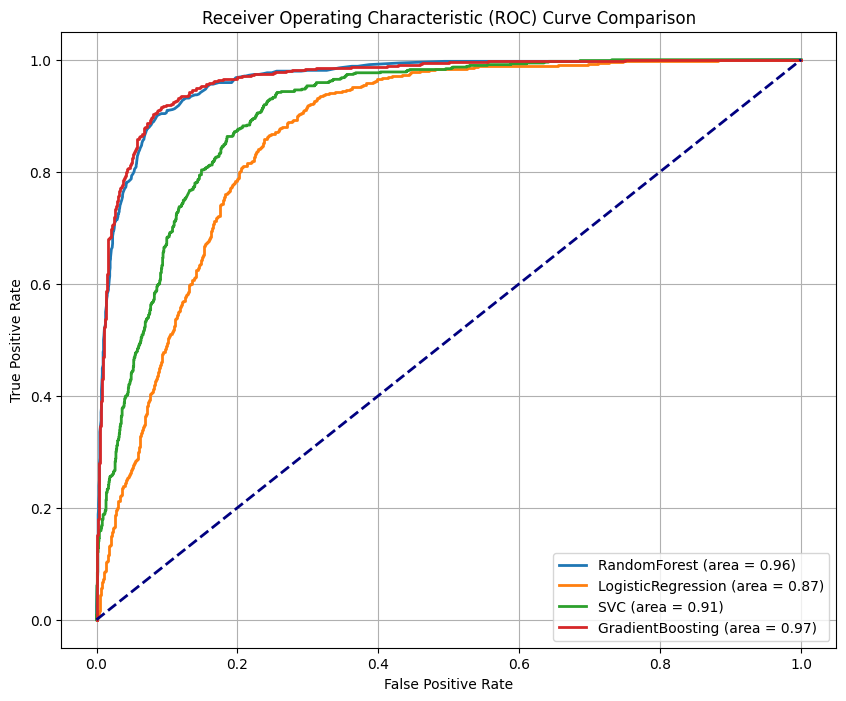


Best performing model: GradientBoosting with ROC AUC: 0.9657


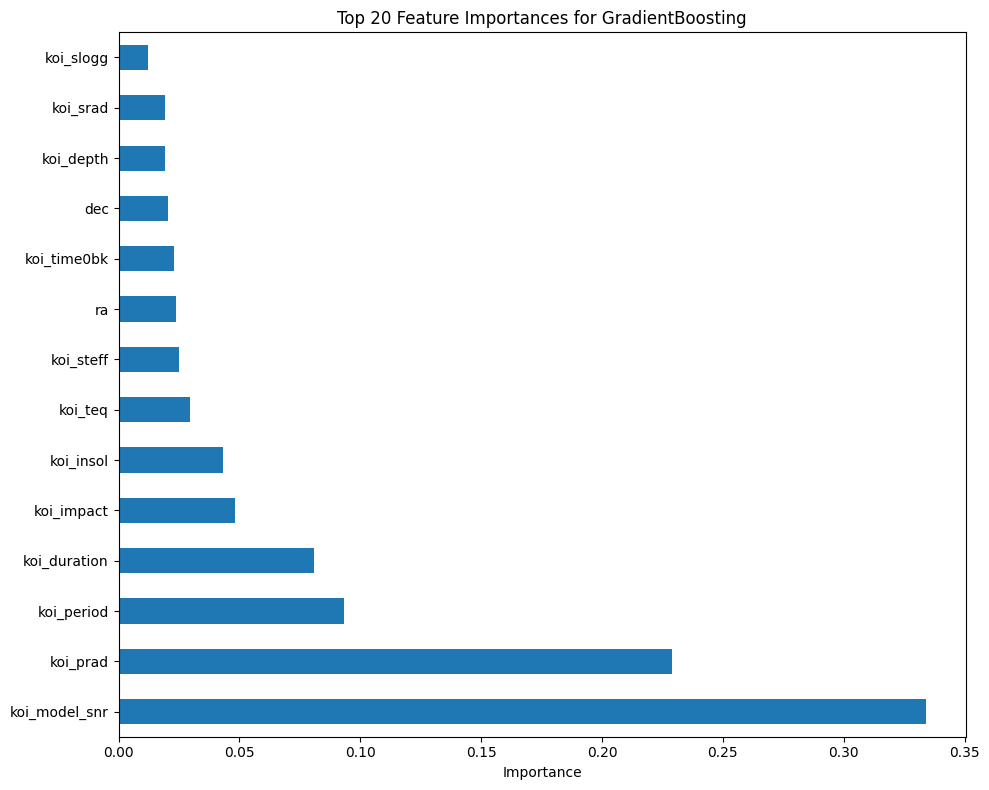

In [71]:
# --- 5. Final Model Evaluation and Comparison ---
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

plt.figure(figsize=(10, 8))
best_model_name = None
best_roc_auc = 0
best_model = None

for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n--- Evaluation for {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name
        best_model = model

    # Plot ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'roc_curve_comparison.png'))
plt.show()

print(f"\nBest performing model: {best_model_name} with ROC AUC: {best_roc_auc:.4f}")

# --- Feature Importance for the Best Model ---
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=features)
    plt.figure(figsize=(10, 8))
    feature_importances.nlargest(20).plot(kind='barh')
    plt.title(f"Top 20 Feature Importances for {best_model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'feature_importance.png'))
    plt.show()
else:
    print(f"\nFeature importance is not available for the best model ({best_model_name}).")

In [72]:

# --- 6. Save the Final Model, Scaler, and Selected Features ---
import joblib
import json

# Save the tuned model
joblib.dump(best_model, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/exoplanet_model_ML_dataset.pkl')

# Save the scaler
joblib.dump(scaler, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/scaler_ML_dataset.pkl')

joblib.dump(imputer, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/imputer.pkl')
# Save the list of selected feature names
with open('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/selected_features_ML_dataset.json', 'w') as f:
    json.dump(features, f)

print("Final model, scaler, and feature list have been saved.")


Final model, scaler, and feature list have been saved.


In [73]:
#load the model
import joblib
model = joblib.load('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/exoplanet_model_ML_dataset.pkl')
scaler = joblib.load('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/scaler_ML_dataset.pkl')
ml_scaler = joblib.load('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/scaler_ML_dataset.pkl')
ml_imputer = joblib.load('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/imputer.pkl')
with open('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/selected_features_ML_dataset.json', 'r') as f:
    ml_features = json.load(f)

def predict_ml(input_df):
    # Ensure input_df has the correct columns
    input_df = input_df[ml_features]
    
    # Impute missing values
    input_imputed = ml_imputer.transform(input_df)
    
    # Scale the imputed data
    input_scaled = ml_scaler.transform(input_imputed)
    
    # Make predictions
    prediction = model.predict(input_scaled)
    prediction_proba = model.predict_proba(input_scaled)[:, 1]
    
    return prediction, prediction_proba


--- Evaluation for the loaded model ---
Accuracy: 0.9138
Precision: 0.8571
Recall: 0.8397
F1-score: 0.8483
ROC AUC: 0.9657


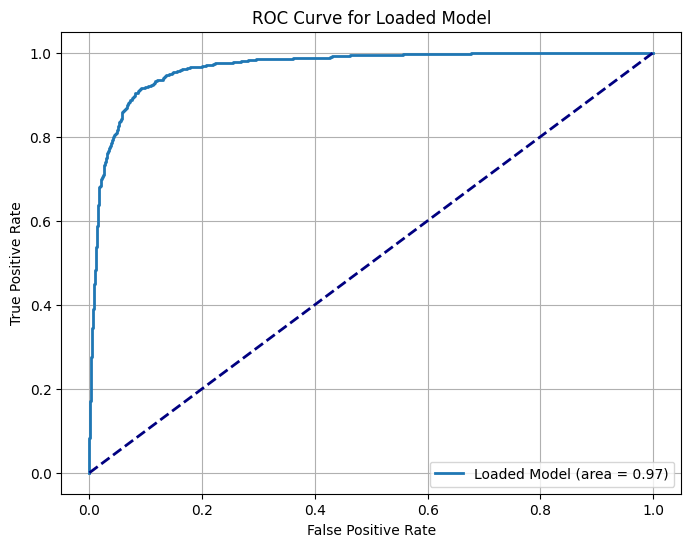

In [74]:
# Test the loaded model on the test data
y_pred_loaded = model.predict(X_test_scaled)
y_prob_loaded = model.predict_proba(X_test_scaled)[:, 1]

# --- Evaluation for the loaded model ---
print("--- Evaluation for the loaded model ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_loaded):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_loaded):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_loaded):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_loaded):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_loaded):.4f}")

# Plot ROC curve for the loaded model
fpr, tpr, _ = roc_curve(y_test, y_prob_loaded)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'Loaded Model (area = {roc_auc_score(y_test, y_prob_loaded):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loaded Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [79]:
# Test best model on new data using kepid and orbital period

# Example: find a row in kiodata by kepid and koi_period, then predict
kepid_example = 10797460
# koi_period_example = 9.488036

row = kiodata[(kiodata['kepid'] == kepid_example)] # & (kiodata['koi_period'] == koi_period_example)]
if not row.empty:
    # Extract features in the correct order
    input_features = row[features]
    input_scaled = scaler.transform(input_features)
    pred = model.predict(input_scaled)
    pred_prob = model.predict_proba(input_scaled)[:, 1]
    print(f"Prediction: {'Exoplanet' if pred[0] == 1 else 'Not an Exoplanet'} with probability {pred_prob[0]:.4f}")
else:
    print("No matching row found for the given kepid and koi_period.")


Prediction: Exoplanet with probability 0.9743


In [76]:
# --- 7. Test on a Single Data Point ---
# Let's get a row from the original dataframe that was used for training
test_row = df_work.sample(6, random_state=1)
display(test_row)

# Extract features and predict
input_features_4 = test_row[features]
input_scaled_4 = scaler.transform(input_features_4)
pred_4 = model.predict(input_scaled_4)
pred_prob_4 = model.predict_proba(input_scaled_4)[:, 1]

# Get the original kepid and koi_period to show which one was tested
original_row = df.loc[test_row.index]
kepid_example_4 = original_row['kepid'].values[0]
koi_period_example_4 = original_row['koi_period'].values[0]


print(f"Prediction for kepid {kepid_example_4}: {'Exoplanet' if pred_4[0] == 1 else 'Not an Exoplanet'} with probability {pred_prob_4[0]:.4f}")
print(f"Actual: {'Exoplanet' if test_row[target].values[0] == 1 else 'Not an Exoplanet'}")

,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec
9066,0,0.933697,131.586700,0.570,4.4440,81.4,0.78,1680.0,1891.43,10.8,5619.0,4.558,0.838,292.19583,47.661518
3891,0,1.691194,132.933230,0.903,9.4790,2801.0,6.36,1528.0,1292.50,26.7,5780.0,4.438,1.000,294.25079,38.404236
4905,0,57.059999,164.257060,0.194,7.4630,66168.0,22.31,455.0,10.11,751.5,5931.0,4.545,0.863,287.34946,38.286041
5835,0,1.891299,132.663900,0.699,5.2940,82.0,0.86,1414.0,944.68,29.8,5806.0,4.507,0.893,290.35153,37.948570
218,1,11.523067,131.969055,0.000,3.8757,507.3,3.13,927.0,174.81,142.0,5644.0,4.162,1.411,284.48245,44.398041
5194,0,495.710950,450.034800,0.718,4.5140,443.1,4.41,330.0,2.80,8.5,6054.0,3.911,1.953,298.88452,41.300442


Prediction for kepid 10471174: Not an Exoplanet with probability 0.0047
Actual: Not an Exoplanet


In [77]:
# what features are necessary to predict exoplanets
if 'best_model' in locals() and hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=features)
    sorted_importances = feature_importances.sort_values(ascending=False)
    
    # Create a DataFrame for better display
    importance_df = pd.DataFrame({
        'Feature': sorted_importances.index,
        'Importance': sorted_importances.values
    })
    
    display(importance_df)

else:
    print("The best model or feature importances are not available. Please run the model training cells first.")

,Feature,Importance
0,koi_model_snr,0.333870
1,koi_prad,0.228851
2,koi_period,0.093136
3,koi_duration,0.080783
4,koi_impact,0.048138
5,koi_insol,0.043141
6,koi_teq,0.029397
7,koi_steff,0.024987
8,ra,0.023569
9,koi_time0bk,0.022935
